# Stellar spectra    B. LTE Line Formation  

**Jakob Borg**

***Instructions*** *This is the template for submitting SSB answers. These instructions are slightly different from SSA, so please read carefully. Copy this file to another file called `SSB_name.ipynb`, where name is your name. Make your edits there, and if you make a mistake deleting a question or code, you can always consult this file again. Write also your name in the space above. This notebook contains all the questions in green blocks for easier visibility. In addition, it also contains the most important bits of code provided so you don't have to copy paste back and forth. Feel free to edit the code if you want, and please delete any code you will not use. Do not delete the questions. Write your answers in the cells below the questions. While only one empty cell appears before the question blocks, feel free to add any quantity of cells (code or Markdown) in the order and quantity you see fit. You can also modify the header below to suit your needs, but please don't use any non-standard packages. If you must, you can include external data files (e.g. temporary results that you saved to avoid long computations), but be sure to include all the code to produce those files. Do not load external code or use any non-standard packages. The whole notebook must run without any errors in the code.*

***A note on collaboration*** *Collaborating with other students is encouraged during these exercises, in particular to discuss the questions, possible approaches, and compare solutions. However, do not write the answer as a group. Do not copy the answer from another student. Compose your answers by yourself.*

*Note that the 3D model is not available on this repository, you must [download](https://folk.uio.no/tiago/teaching/ast4310/h19/qs006024_sap_s285.fits) it by yourself!*

### Header and imports

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.table import QTable  # To use tables with units
from astropy.modeling.blackbody import blackbody_lambda
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
from numpy import newaxis as nax  # to simplify the many uses of this

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=True)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=12)

from scipy.integrate.quadrature import cumtrapz   # for tau integration
from scipy.ndimage import shift  # for "rotating" 3D cubes
from scipy.special import wofz   # for Voigt function

i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

In [3]:
plt.style.use('bmh')

## Rcparams file config
rcconfig = {'font.size'             : 12.0,
            'text.usetex'           : False,
            'text.latex.preamble'   : ('\\usepackage{physics}','\\usepackage{siunitx}'),
            'figure.constrained_layout.use'     :True,
            'figure.constrained_layout.h_pad'   :0.07,
            'figure.constrained_layout.w_pad'   :0.05,
            'figure.titlesize'      : 'x-Large',
            'axes.titlesize'        : 'medium',
            'path.simplify'         : True}

for key,val in rcconfig.items():
    mpl.rcParams[key] = val

## Disclaimer
Where it isn't overly time consuming, I have made most of my code cells not dependent on variables from previous cells in order to reduce the chance for leaking errors and bugs. This way many of the cells reinitialize quantities that are already used.

Unfortunately I have note been able to work on this project even remotely close to as long as I had hoped due to illness and other projects. Therefore some of the questions are only partially answered as I've focused on getting through as much of the project as possible without spending too much time on details.

## 1. Stratification of the Solar Atmosphere

In [4]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    """
    tmp = np.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

In [5]:
falc = read_table_units("falc.dat")
falc

height,tau_500,colmass,temperature,v_turb,hydrogen_density,proton_density,electron_density,pressure,p_ratio,density
m,,kg / m2,K,m / s,1 / m3,1 / m3,1 / m3,N / m2,,kg / m3
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2218200.0,0.0,6.777e-05,100000.0,11730.0,5574999999999999.0,5574999999999999.0,6664999999999999.0,0.01857,0.952,1.3059999999999998e-11
2216500.0,7.696e-10,6.779e-05,95600.0,11650.0,5837999999999999.0,5836999999999999.0,6946999999999999.0,0.01857,0.95,1.3679999999999998e-11
2214890.0,1.531e-09,6.781e-05,90816.0,11560.0,6150999999999999.0,6149999999999999.0,7283999999999999.0,0.01858,0.948,1.4409999999999997e-11
2212770.0,2.597e-09,6.785e-05,83891.0,11420.0,6667999999999999.0,6666999999999999.0,7833999999999999.0,0.018590000000000002,0.945,1.562e-11
2210640.0,3.754e-09,6.788000000000001e-05,75934.0,11250.0,7380999999999999.0,7377999999999999.0,8575999999999999.0,0.018600000000000002,0.941,1.729e-11
2209570.0,4.384e-09,6.79e-05,71336.0,11140.0,7863999999999999.0,7857999999999999.0,9075999999999998.0,0.018600000000000002,0.938,1.8429999999999998e-11
2208480.0,5.065e-09,6.792e-05,66145.0,11020.0,8487999999999999.0,8475999999999999.0,9717999999999998.0,0.018609999999999998,0.935,1.989e-11
2207380.0,5.814e-09,6.794e-05,60170.0,10860.0,9333999999999998.0,9306999999999998.0,1.0589999999999998e+16,0.01862,0.931,2.1869999999999998e-11


### 1.2 FALC Relations

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">


* Plot the total pressure $p_{\rm total}$ against the column mass $m$, both linearly and logarithmically.  You will find that they scale linearly.  Explain what assumption has caused $p_{\rm total} = c\,m$ and determine the value of the solar surface gravity $g_{\rm surface} = c$ that went into the FALC-producing code.

* [Fontenla et al. (1993)](http://adsabs.harvard.edu/abs/1993ApJ...406..319F) also assumed complete mixing, *i.e.* the same elements mix at all heights. Check this by plotting the ratio of the hydrogen mass density to the total mass density against height. Then add helium to hydrogen using their abundance and mass ratios ($N_{\rm He}/N_{\rm H} = 0.1$, $m_{\rm He} = 3.97 \, m_{\rm H}$), and estimate the fraction of the total mass density made up by the remaining elements in the model mix (the "metals").

* Create a plot of the gas pressure against height, and then overplot the product $(n_{\rm H} + n_{\rm e}) \, k_B T$. Plot the ratio of the two curves to show their differences.  Do the differences measure deviations from the ideal gas law or something else? Now add the helium density $n_{\rm He}$ to the product and enlarge the deviations. Do you see a pattern emerging? Comment on what could be missing between your calculations and the gas pressure from the model.

* Plot the ionisation fraction of hydrogen logarithmically against height. Why does this curve look like the temperature stratification plotted earlier? And why is it tilted with respect to that?

* Let us now compare the photon and particle densities. In thermodynamic equilibrium (TE) the radiation is isotropic with intensity $I_\nu = B_\nu$ and has total energy density (Stefan Boltzmann)
    \begin{equation*}
         u = \frac{1}{c} \int\!\!\!\int B_\nu \mathrm{d}\Omega \mathrm{d}\nu
           = \frac{4\sigma}{c} T^4,
      \end{equation*} so that the total photon density for isotropic TE radiation is given, with $u_\nu = \rm{d} u/\rm{d} \nu$, by  
    \begin{equation*}
         N_{\rm phot} = \int_0^\infty \frac{u_\nu}{h\nu} \mathrm{d} \nu
            \approx 60.42\,\left(\frac{k_B T}{hc}\right)^3.
         \label{eq:20T3}
      \end{equation*} 
    This equation gives a reasonable estimate for the photon density at the deepest model location. Compute the value there and compare it to the hydrogen density. Conjecture why this equation is not valid higher up in the atmosphere. 
      
* In the upper atmosphere, the photon density there is given by 
$$
N_{\rm phot} \approx \frac{60.42}{2\pi}\,\left(\frac{k_B T_{\rm eff}}{hc}\right)^3,
$$
with $T_{\rm eff} = 5777$ K the effective solar temperature (since $\pi B(T_{\rm eff}) = \sigma T_{\rm eff}^3 = {\cal F^+} = \pi \overline{I^+}$ with ${\cal F^+}$ the emergent flux and $\overline{I^+}$ the disk-averaged emergent intensity). Compare it to the hydrogen density at the highest location in the FALC model. The medium there is insensitive to these photons (except those at the centre wavelength of the hydrogen Ly $\alpha$ line), why?

</div>

__*Answers:*__

  > The linear relation between the pressure and column mass is due to the assumption of hydrostatic equilibrium. Assuming only pressure forces and gravity, for equilibrium these forces must be equal at each height. Using the column mass is especially useful here, as its all the mass of the medium in a unit area above the given height, so we can express the pressure as
$$ P_\rm{tot}(h) = c(h)m(h)$$
where $c(h)$ is the "constant" at height $h$. Solving this for $g_\rm{surface} = c(h_\rm{surface})$ is easy numerically using that $\tau_\rm{500} = 1$ at the surface. We could also use that the height is defined equal zero at this point. Solving for the surface gravity gives  
$$ g_\rm{surface} = \frac{P_\rm{tot}(h_\rm{surface})}{m(h_\rm{surface})} = 282.123 \, \rm{N\,kg^{-1}}.$$  
Note that a figure with both axis logarithmically is not included, as it looks identical to the linear case.

The surface gravity acceleration g_s = 282.123 N / kg


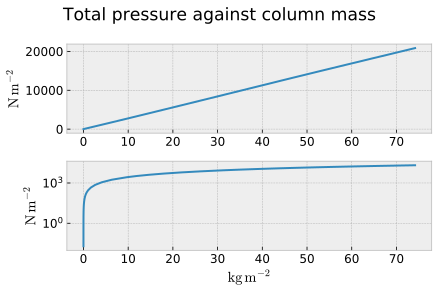

In [6]:
# Extracting the total pressure and column mass
p_tot = falc['pressure'] + falc['density']*falc['v_turb']**2/2
m_col = falc['colmass']

# Finding surface gravity
tau_500 = falc['tau_500']
id_surface = np.argmin(np.abs(tau_500-1)) # index of tau = 1
g_surface = p_tot[id_surface]/m_col[id_surface]
print('The surface gravity acceleration g_s = {:.3f}'.format(g_surface))

# Plotting the total pressure vs column mass
fig,ax = plt.subplots(2)
fig.suptitle('Total pressure against column mass')
ax[0].plot(m_col.value,p_tot)
ax[1].semilogy(m_col,p_tot);

  > In the figures below the ratios of mass density of hydrogen, hydrogen and helium combined and the metals to the total mass density are plotted. We see that the distribution is quite chaotic in height. The majority of the density being composed of hydrogen, with a mean density ratio of $0.7138$. To find the helium density we use the abundance of helium to hydrogen, and the relation between the helium mass and proton mass $$\rho_\rm{He} = 0.1 n_\rm{H} m_\rm{He}.$$ When the helium is added as well the mean ratio ratio creeps up to $0.9972$. To estimate the density of the metals we use that, well, they are the _remaining_ elements, so the ratio of them is just what is left after removing the hydrogen and helium $$\frac{ \rho_\rm{metals} }{ \rho_\rm{tot} } = 1 - \frac{ \rho_\rm{H + He} }{ \rho_\rm{tot} }$$ which produces the reverse curve to the two other figures, with a low mean ratio of $0.0028$.

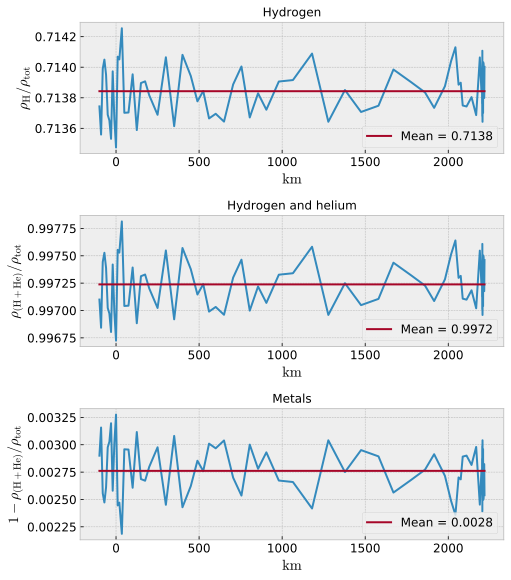

In [7]:
n_H = falc['hydrogen_density']
density_tot = falc['density']
height = falc['height'].to('km')
mass_p = constants.m_p
mass_He = 3.97*mass_p
H_tot_ratio = n_H*mass_p/density_tot
H_He_ratio = H_tot_ratio + n_H*0.1*mass_He/density_tot
metals_ratio = 1 - H_He_ratio
ratios = [H_tot_ratio,H_He_ratio,metals_ratio]
titles = ['Hydrogen','Hydrogen and helium','Metals']
y_labels = [r'$\rho_{\rm{H}}/\rho_{\rm{tot}}$',
            r'$\rho_{(\rm{H}+\rm{He})}/\rho_{\rm{tot}}$',
            r'$1-\rho_{(\rm{H}+\rm{He})}/\rho_{\rm{tot}}$']

fig,ax = plt.subplots(3,figsize=(7,8))
for i in range(3):
    mean = np.mean(ratios[i])
    ax[i].set_title(titles[i])
    ax[i].plot(height,ratios[i])
    ax[i].plot(height,np.ones(height.shape)*mean,label='Mean = {:.4f}'.format(mean))
    ax[i].set_ylabel(y_labels[i])
    ax[i].legend(loc=4);

  > Plotting the pressure for the three cases in the top plot below, shows that the pressure decrease rapidly from zero height and up as expected. The red and purple curves are the pressure obtained using the ideal gas law and the total number density of the two composite gases, one not including helium and one which does. We then inspect the ratio plot for their differences. First the blue curve, showing the ratio of the gas pressure to the pressure contribution from hydrogen and electrons calculated using the ideal gas law. The curve clearly shows some deviations from the ideal gas law, both in that the ratio is not close to one and that it is not constant. When we add the helium density as well, we see that the ratio approaches one at height $\sim 300 \, \rm{km}$. The emerging pattern seems to be that the ratio progressively approaches one when we include all the involved elements. As we saw earlier when inspecting the ratios of densities of hydrogen and helium to the total density, the two lightest elements makes up the majority of the total mass. So we would expect the ratio of the pressure to be close to one when including helium, but this is not the case for all heights.  This indicate that the ideal gas law is not a good approximation in this model. First this discrepancy was thought to be caused by the missing turbulence in the ideal gas law, but it seems that the model is not including this in the gas pressure, but in the total pressure. Thus this is probably not a correct explanation for the discrepancy.

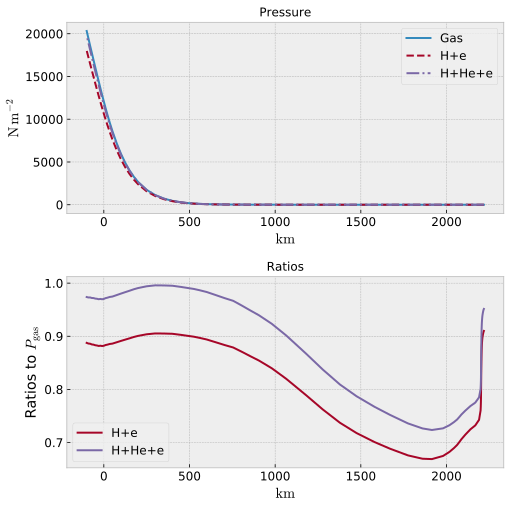

In [51]:
p_gas = falc['pressure']#  + falc['density']*falc['v_turb']**2/2  # testing with and without the turbulence
temp = falc['temperature']
height = falc['height'].to('km')
n_H = falc['hydrogen_density']
n_e = falc['electron_density']
n_He = 0.1*n_H

kT = (constants.k_B*temp).to('N m')
p_H_e = (n_H+n_e)*kT
p_H_He_e = p_h_e + n_He*kT


fig, ax = plt.subplots(2,figsize=(7,7))

ax[0].plot(height,p_gas,label='Gas')
ax[0].plot(height,p_H_e,'--',label='H+e')
ax[0].plot(height,p_H_He_e,'-.',label='H+He+e')
ax[0].set_title('Pressure')

ax[1].plot(height,p_H_e/p_gas,label='H+e',color='C1')
ax[1].plot(height,p_H_He_e/p_gas,label='H+He+e',color='C2')
ax[1].set_ylabel(r'Ratios to $P_{\rm{gas}}$')
ax[1].set_title('Ratios')

for ax in ax.flatten():
    ax.legend();

  > We plot the ionization fraction of hydrogen by taking the ratio between proton and total hydrogen density, with logarithmic y axis. The ratio has a strikingly resemblance with the temperature stratification, replotted below for comparison. This resemblance is due to the high temperature dependency in the Saha distribution which describe the ionization fractions.  
The tilted effect may be due to the non-linear dependency on temperature in the Saha distribution. It scales with temperature as 
$$\frac{n_{r+1,2}}{n_{r,s}} \propto T^{3/2} e^{-1/T}$$
which will deviate more on higher temperatures/higher up in the atmosphere compared to a linear dependency. The result is that the two curves are tilted with respect to each other at the high end of the curve.

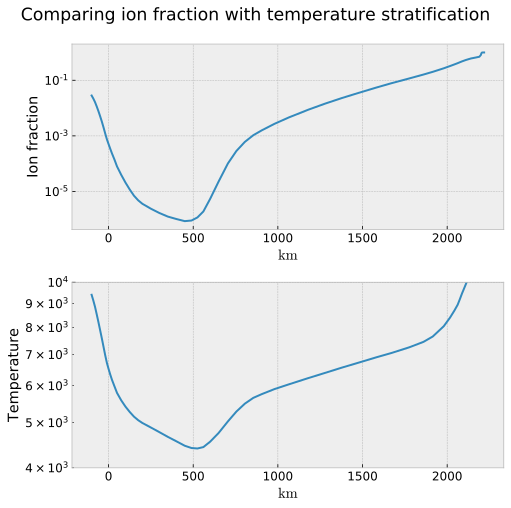

In [52]:
n_p = falc['proton_density']
n_h = falc['hydrogen_density']
height = falc['height'].to('km')
ion_frac = n_p/n_h

fig, ax = plt.subplots(2,figsize=(7,7))
ax[0].plot(height,ion_frac)
ax[0].set_ylabel('Ion fraction')
ax[1].plot(height,falc['temperature'].value)
ax[1].set_ylabel('Temperature')
ax[1].set_ylim(4000, 10000)
fig.suptitle('Comparing ion fraction with temperature stratification')

for x in ax.flatten():
    x.set_yscale('log');

  > By using the provided expressions we calculate the photon density at the deepest model location, height $-100 \, \rm{km}$, by inserting the temperature at this height. We find the photon density here to be $n_{\rm{phot}}^{\rm{deep}} = 1.685 \times 10^{19} \, \rm{m^{-3}}$. We also find the ratio to the hydrogen density at the same height to be $1.247\times 10^{-4}$, indicating a quite low abundance of photons here (relative to H).  
  Similarly we find the density near the upper atmosphere to be $n_{\rm{phot}}^{\rm{top}} = 6.225\times 10^{17} \, \rm{m^{-3}}$ with abundance $111.7$. Note that the abundance is dramatically changed by 6 orders of magnitude, now with an overabundance of photons relative to hydrogen.
  
  > The first equation assumes TE, which is a decent approximation in the deepest part of the model. From the temperature stratification curve we have seen that the change in temperature in this region is relatively low (within the same order of magnitude). Higher up in the atmosphere the temperature rises dramatically, and so TE is a poor approximation and the equation will cease to hold the higher we go. A final figure of the temperature stratification is shown below, without limiting the y-axis, to better show the discussed behavior. Along the way from the deepest end to the top, we have seen that the ratio of photons to hydrogen (the majority of the total gas) is more or less flipped on its head. The change in photon abundance and gas density will affect which type of transition processes which will dominate, and this in turn might also affect the TE approximation. A possible improvement would be to instead introduce a local TE (LTE).
  
> Why the medium in the highest region of the FALC model is insensitive to the photons may be explained by the large abundance of photons relative to hydrogen (and everything else). This means that the radiative excitation and induced radiative deexcitation (as well as spontaneous radiative deexcitiation) are the most important transition processes, with the collisional ones being negligible. Due to the low density, and thus high mean free path, the photons will merely scatter through the medium.

Height -100 km
Photon density = 1.685e+19 1 / m3
Ratio to hydrogen density 1.247e-04

Height 2218.20 km
Photon density = 6.225e+17 1 / m3
Ratio to hydrogen density 1.117e+02

Ratio of upper to deep photon density 3.694e-02



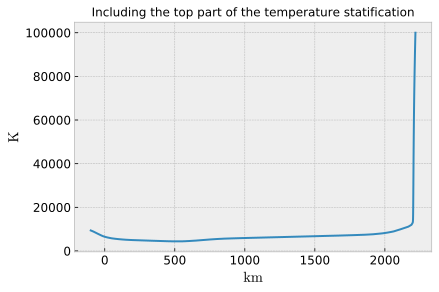

In [54]:
n_h = falc['hydrogen_density']
T = falc['temperature']
height = falc['height'].to('km')
T_eff = 5777*units.K

const_cubed = (constants.k_B/(constants.h*constants.c))**3
N_phot_deep = 60.42*const_cubed*T[-1]**3
N_phot_upper = 60.42/2/np.pi*const_cubed*T_eff**3

# Deep part
print('Height {:.0f}'.format(height[-1]))
print('Photon density = {:.3e}'.format(N_phot_deep))
print('Ratio to hydrogen density {:.3e}\n'.format(N_phot_deep/n_h[-1]))
# Top part
print('Height {:.2f}'.format(height[0]))
print('Photon density = {:.3e}'.format(N_phot_upper))
print('Ratio to hydrogen density {:.3e}\n'.format(N_phot_upper/n_h[0]))

print('Ratio of upper to deep photon density {:.3e}\n'.format(N_phot_upper/N_phot_deep))

# Temperature stratification without y-lim
fig,ax = plt.subplots()
ax.plot(height,T)
ax.set_title('Including the top part of the temperature statification');

### 1.3 A 3D model atmosphere

In [48]:
atm3d = QTable.read("qs006024_sap_s285.fits")
atm3d;

### 2.1 Observed Solar Continua

In [107]:
i_scale = units.Quantity(1e10, unit='erg cm-2 s-1 um-1 sr-1').to(i_units)
wave_obs, f_smooth, f_cont, i_smooth, i_cont = np.loadtxt("solspect.dat", unpack=True)
wave_obs = wave_obs * units.um
f_smooth = f_smooth * i_scale
f_cont = f_cont * i_scale
i_smooth = i_smooth * i_scale 
i_cont = i_cont * i_scale

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Plot the four spectral distributions together in one figure over the range $\lambda =$ 0-2 μm. Check that the continuum intensity (`i_cont`) reaches $I_\lambda^c =$ 46 kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$  at $\lambda =$ 0.41 μm. Explain why the four distributions share the same units and discuss the differences between them.

* Convert these spectral distributions into values per frequency bandwidth $\Delta \nu =$ 1 Hz. Plot these also against wavelength. Check: peak $I_\nu^c =$ 42.1 nW m$^{-2}$ Hz$^{-1}$ sr$^{-1}$  at $\lambda =$ 0.80 μm.

* Try to fit a Planck function to the solar continuum intensity. What rough temperature estimate do you get?

* Invert the Planck function analytically to obtain an equation which converts an intensity distribution $I_\lambda$ into brightness temperature $T_b$ (defined by $B_\lambda(T_b) \equiv I_\lambda$). Code it as a function and use that to plot the brightness temperature of the solar continuum against wavelength. Discuss the shape of this curve. It peaks near $\lambda =$ 1.6 μm. What does that mean for the radiation escape at this wavelength?
</div>

__*Answers:*__

  > Same units on flux and intensity: Astrophysical flux is defined as $F_{\rm{astro}} = \frac{\mathcal{F}}{\pi}$, which introduce $\rm{sr^{-1}}$ in the units of the astrophysical flux. Thus the units of the intensity and astrophysical flux is the same, $\rm{W \, m^{-2} \, Hz^{-1} \, sr^{-1}}$. They have the same units, but they still differ; the flux is the avaraged total energy flow, while the intensity is location specific and dependent on direction.
We check the value obtained from the continuum intensity at wavelength $\lambda = 0.41 \, \rm{\mu m}$ and find the exact expected intensity of $46.0 \, \rm{kW \, m^{-2} \, nm^{-1} \, sr^{-1}}$.

In [108]:
# Check value
id_wave = np.argmin(np.abs(wave_obs.value-0.41))
expected = units.Quantity(46, unit='kW m-2 nm-1 sr-1')
print('Continuum intensity at wavelenth {}\n Calculated I = {}\n Absolute difference from expected = {}'.format(wave_obs[id_wave],i_cont[id_wave],np.abs(expected-i_cont[id_wave])))

Continuum intensity at wavelenth 0.41 um
 Calculated I = 46.0 kW / (m2 nm sr)
 Absolute difference from expected = 0.0 kW / (m2 nm sr)


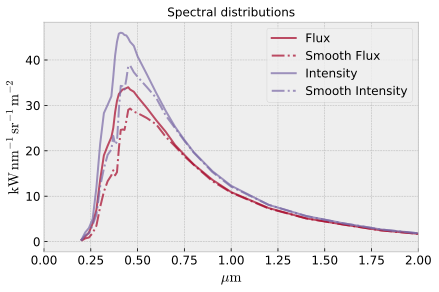

In [109]:
fig, ax = plt.subplots()
ax.plot(wave_obs,f_cont,label='Flux',alpha=0.7,color='C1')
ax.plot(wave_obs,f_smooth,'-.',label='Smooth Flux',alpha=0.7,color='C1')
ax.plot(wave_obs,i_cont,label='Intensity',alpha=0.7,color='C2')
ax.plot(wave_obs,i_smooth,'-.',label='Smooth Intensity',alpha=0.7,color='C2')
ax.set_title('Spectral distributions')
ax.set_xlim(0,2)
ax.legend();

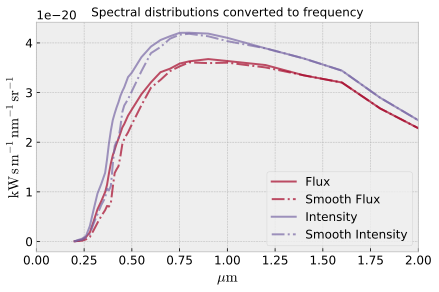

In [111]:
dlambda_dnu = -wave_obs**2/constants.c
i_cont_freq = -i_cont*dlamda_dnu
i_smooth_freq = -i_smooth*dlamda_dnu
f_cont_freq = -f_cont*dlamda_dnu
f_smooth_freq = -f_smooth*dlamda_dnu

fig, ax = plt.subplots()
ax.plot(wave_obs,f_cont_freq,label='Flux',alpha=0.7,color='C1')
ax.plot(wave_obs,f_smooth_freq,'-.',label='Smooth Flux',alpha=0.7,color='C1')
ax.plot(wave_obs,i_cont_freq,label='Intensity',alpha=0.7,color='C2')
ax.plot(wave_obs,i_smooth_freq,'-.',label='Smooth Intensity',alpha=0.7,color='C2')
ax.set_title('Spectral distributions converted to frequency')
ax.set_xlim(0,2)
ax.legend();

### 2.2 Continuous Extinction

In [101]:
def compute_hminus_extinction(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (array)
        Wavelength(s) to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    electron_density: astropy.units.quantity (scalar or array)
        Electron density in units of per cubic length.
        
    Returns
    -------
    extinction : astropy.units.quantity (scalar or array)
        Total H- extinction in si units. 
        Shape: shape of temperature + (nwave,)
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * units.K / temp
    electron_pressure = electron_density[..., nax] * constants.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = numpy.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = numpy.polyval(sigma_coeff, wave.to('AA'))
    sigma_bf = sigma_bf * 1.e-22 * units.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * units.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * units.cm ** 2 / units.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf *= (1 - numpy.exp(-constants.h * constants.c / (wave * constants.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = numpy.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                          [-0.142631, 1.99381, -9.2846, 15.2827],
                          [-0.625151, 10.6913, -67.9775, 190.266, -197.789]])
    log_wave = numpy.log10(wave.to_value('AA'))
    log_theta = numpy.log10(theta)
    tmp = 0
    for i in range(3):
        tmp += numpy.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp) 
    kappa_ff = kappa_ff * 1e-26 * (units.cm ** 4) / units.dyn
    return (kappa_bf + kappa_ff).si

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Hydrogenic bound-free edges behave just as H$^-$ with maximum extinction at the ionisation limit and decay $\sim \lambda^3$ for smaller wavelengths, as indeed shown by the H$^-$ curve. The H$^-$ bound-free extinction differs strongly from this pattern. Why is it not hydrogenic although due to hydrogen?

* How should you plot this variation to make it look like the solar brightness temperature variation with wavelength? Why?

* Plot the variation of the H$^-$ extinction per m with height for $\lambda =$ 0.5 μm. This plot needs to be logarithmic in y, why?

* Now add the Thomson scattering off free electrons to the extinction per m. The Thomson cross-section per electron is the same at all wavelengths and is given by       
\begin{equation*}
        \sigma^{\rm T} = 6.648 \times 10^{-29} \rm{m}^2.
\end{equation*} 
By which height-dependent quantity do you have to multiply this number to obtain extinction per m? Overplot this contribution to the continuous extinction $\alpha_\lambda^c(h)$ in your graph and then overplot the total continuous extinction too.  Note where which effect dominates.
    
</div>

*Your answers here*

### 2.3 Optical Depth

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* There is something missing in the plot above. As you've done in the previous questions, compute the total continuum extinction from H$^-$ plus Thomson scattering, and re-do the $\tau$ calculation and recreate the plot.

* Now calculate $\tau_{500}$ for the 3D model (again using H$^-$ plus Thomson scattering). You should be able to run `compute_hminus_extinction` and `cumtrapz` as in the 1D case, with no loops. There is no `proton_density` available for the 3D model, so just use `hydrogen_density` in `compute_hminus_extension`. Each column in the 3D model is like a different 1D atmosphere, so each column has a different $\tau_{500}$. There are 256x256 columns in the 3D model, so it makes little sense to plot them all. Choose a small number of them and plot them in as function of height (all in one figure).

* In the 3D case $h(\tau_{500}=1)$, the height where $\tau_{500} =$ 1 (when the atmosphere becomes transparent for 500 nm), varies along the horizontal dimensions. Using your already calculated $\tau_{500}$, calculate and plot $h(\tau_{500}=1)$. For this calculation, one usually has to interpolate the $\tau_{500}$ vs $h$ curve for each line in the model, but a very quick calculation can be made by taking the model height where $\tau_{500}$ is closest to 1 (nearest neighbour) with `tau1_height = height[numpy.abs(tau - 1).argmin(axis=0)]`, replacing `height` and `tau` by the appropriate arrays. Show $h(\tau_{500}=1)$ as a 2D plot (image) and as a 3D surface plot (see below for hints on how to make this plot).
    
* ***Bonus question*** *(optional, points will be used to make up for lost points elsewhere)*: the 3D plot from the previous question will look rough because of the use of nearest neighbour. Create a smooth version of this plot by using linear interpolation for $h(\tau_{500}=1)$.
  
</div>

*Your answers here*

### 2.4 Emergent intensity and height of formation

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
 
* Re-do the plot above for the peak-normalised contribution function against height the location of `hmean` using the total extinction (H$^-$ plus Thomson scattering). 
    
* Repeat the above normalised contribution plot for $\lambda =$ 1 μm, $\lambda =$ 1.6 μm, and $\lambda =$ 5 μm (all in same plot). Discuss the changes of the contribution functions and their cause.
</div>

*Your answers here*

### 2.5 1D intensity from different directions

In [ ]:
def lte_intensity_1D(wavelength, distance, temperature, extinction, mu):
    """
    Solves the radiative transfer equation assuming LTE for a single ray.
    
    Parameters
    ----------
    wavelength: astropy.units.quantity (1-D array)
        Wavelengths to calculate, in units of length.
    distance : astropy.units.quantity (1-D array)
        Distances along path of ray, in units of length. Can be different
        length than wavelength array.
    temperature: astropy.units.quantity (n-D array)
        Gas temperature in units of K or equivalent, for all points along
        the ray. Same length as distance.
    extinction: astropy.units.quantity (1D + n-D array)
        Extinction coefficient in units of inverse length, for all
        wavelengths and points along the ray. The shape of this array
        should be `(npath, nwave)`, where nwave is number of wavelength
        points, and npath number of points the ray crosses. npath
        can also be multidimensional, so the shape could be `(nz, ny, nx, nwave)`
        or `(nz, nwave)`.
    mu: float
        Cosine of angle relative to normal of surface. Use 1.0 for
        emergent intensity, mu < 1 for inclined rays.
    """
    tau = cumtrapz(extinction, x=distance, initial=0, axis=0)
    source_function = blackbody_lambda(wavelength[nax], 
                                       temperature[..., nax])
    return numpy.trapz(source_function * numpy.exp(-tau / mu), tau / mu, axis=0)


def compute_continuum(wavelength, temperature, electron_density, hydrogen_density, 
                      distance, mu):
    """
    Calculates emergent continuum intensity assuming only H- ff
    plus Thomson scattering.
    
    Parameters
    ----------
    wavelength: astropy.units.quantity (1-D array)
        Wavelengths to calculate, in units of length.
    temperature: astropy.units.quantity (n-D array)
        Gas temperature in units of K or equivalent, for all points along
        the ray. First dimension should be same length as distance.
    electron_density: astropy.units.quantity (n-D array)
        Electron density in units of m^-3 or equivalent, for all points along
        the ray. Same dimensions as temperature.
    hydrogen_density: astropy.units.quantity (n-D array)
        Hydrogen density in units of m^-3 or equivalent, for all points along
        the ray. Same dimensions as temperature.
    distance : astropy.units.quantity (1-D array)
        Distances along path of ray, in units of length. Can be different
        length than wavelength array.
    mu: float
        Cosine of angle relative to normal of surface. Use 1.0 for
        emergent intensity, mu < 1 for inclined rays.
    """
    hminus_ext = compute_hminus_extinction(wavelength, temperature, electron_density)
    hminus_ext *= hydrogen_density[..., nax]
    thomson_ext = electron_density[..., nax] * 6.648e-29 * units.m ** 2 
    total_ext = hminus_ext + thomson_ext
    intensity = lte_intensity_1D(wavelength, distance, temperature, total_ext, mu)
    return intensity

### 2.6 3D intensity from different directions

In [ ]:
def shift_simulation(data, mu):
    """
    Shifts (or translates) a 3D horizontally periodic simulation according to an
    inclination angle given by mu = cos(angle). 
    
    Parameters
    ----------
    data : astropy.table.table.QTable
        Data from a 3D simulation in QTable format. Should have 
        several 3D variables plus a single 1D variable called "height",
        and some extra metadata.
    mu : float
        Cosine of inclination angle.
    """
    data_shifted = data.copy()
    pixel_size = data.meta['XPIX_KM'] * units.km  # horizontal pixel size
    angle = numpy.arccos(mu)
    shift_pix = data['height'] * numpy.tan(angle) / pixel_size
    data_shifted['height'] /= mu
    ndep = len(data)
    
    for var in data_shifted.keys():
        if data[var].ndim != 3:
            continue
        for i in range(ndep):
            # shift only in x direction:
            data_shifted[var][i] = (shift(data[var][i], 
                                    (shift_pix[i], 0), mode='wrap') *
                                    data[var].unit)
    return data_shifted

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
 
* Compute the continuous intensity at 500 nm from the simulation at two viewing angles: $\mu$=0.4 and 0.2 (about 66° and 78°). Plot both intensity maps with identical physical sizes in the x and y axes.
    
* In 3D space a rotation can be along two angles. Here $\mu$ represents a rotation along the polar angle, but one can also do a rotation around an azimuthal angle. How would you rotate the simulation cubes by an azimuthal angle? (Think multiples of 90° rotations, and it becomes much easier.)
    
*Hints:* you can use `compute_continuum` but need to use $\mu =$ 1, and instead rotate the simulation with `shift_simulation`. By tilting the simulation you will obtain intensity maps that have the same number of pixels (256 x 256), but the rotation compresses the physical size by $\mu$ along the direction that was tilted. You will need to account for that in your plotting. Your result should look like the image below:  
</div>

<img src="images/inclined_Icont.svg" height=300px>

*Your answers here*

### 3.1 The Na I D lines

In [ ]:
wnum, _, sp_obs, _ = numpy.loadtxt("int_nad.dat", unpack=True)
wnum = wnum / units.cm
wave = wnum.to("nm", equivalencies=units.spectral())

fig, ax = plt.subplots()
ax.plot(wave, sp_obs);

#### 3.2.1 Level populations

In [ ]:
class Atom:
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = numpy.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = numpy.empty((self.n_stages, self.max_levels))
        chi.fill(numpy.nan)
        self.g = numpy.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, nax]
        self.loaded = True

    def compute_partition_function(self, temperature):
        """
        Computes partition functions using the atomic level energies and
        statistical weights.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
            
        Returns
        -------
        pfunc : astropy.units.quantity (array)
            Partition function. Shape is (nlevels,) + temperature.shape.
        """
        if not self.loaded:
            raise ValueError("Missing atom structure, please load atom with read_atom()")
        temp = temperature.T[..., nax, nax]  # to allow broadcast
        return numpy.nansum(self.g.T * numpy.exp(-self.chi.T / constants.k_B / temp), axis=-2).T
    
    def compute_excitation(self, temperature):
        """
        Computes the level populations relative to the ground state,
        according to the Boltzmann law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        
        Returns
        -------
        exc : astropy.units.quantity (array)
            Populations of excited states relative to total number of species.
            Shape is (nstages, nlevels) + temperature.shape.
        """
        pfunc = self.compute_partition_function(temperature)
        temp = temperature.T[..., nax, nax]
        # relative to total number of atoms in this stage
        g_ratio = self.g.T / pfunc[:, nax].T
        result = (g_ratio * numpy.exp(-self.chi.T / (constants.k_B * temp))).T
        return result
    
    def compute_ionisation(self, temperature, electron_density):
        """
        Computes ionisation fractions according to the Saha law.
        IMPORTANT: changed from SSA: now takes electron density 
                   instead of electron pressure.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_density: astropy.units.quantity (scalar)
            Electron density in units of m^-3 or equivalent.

        Returns
        -------
        ion_frac : astropy.units.quantity (array)
            Ionisation fraction relative to total number of species.
            Shape is (nstages,) + temperature.shape.
        """
        partition_function = self.compute_partition_function(temperature)
        saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B * 
                       temperature.astype('d')) / (constants.h ** 2)) ** (3 / 2)
        nstage = numpy.zeros_like(partition_function) / units.m ** 3
        nstage[0] += 1. / units.m ** 3
        # Below we use the values for ionisation energies that are saved
        # in the first index of each excited state: self.chi[r + 1, 0]
        for r in range(self.n_stages - 1):
            nstage[r + 1] = (nstage[r] / electron_density * 2 * saha_const *
                             partition_function[r + 1] / partition_function[r] * 
                             numpy.exp(-self.chi_ion[r + 1, nax] / 
                                       (constants.k_B * temperature[nax])))
        # nansum is needed because the last stage might have only one level
        # (only ionisation potential)
        return nstage / numpy.nansum(nstage, axis=0)

    def compute_populations(self, temperature, electron_density):
        """
        Computes relative level populations for all levels and all
        ionisation stages using the Bolzmann and Saha laws.
        IMPORTANT: changed from SSA: now takes electron density 
                   instead of electron pressure.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_density: astropy.units.quantity (scalar)
            Electron density in units of m^-3 or equivalent.
            
        Returns
        -------
        pop_frac : astropy.units.quantity (array)
            Population of different levels relative to total number of species.
            Shape is (nstages, nlevels) + temperature.shape.
        """
        return (self.compute_excitation(temperature) * 
                self.compute_ionisation(temperature, electron_density)[:, nax])

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* ***Bonus question*** *(optional, points will be used to make up for lost points elsewhere)*: calculating the partition function relies on having the level energies for several excited states, but in our simple atom we have only two excited states in neutral sodium. Check how far we are from a better partition function by comparing with the recipe given below at 5000 K and 6000 K.
    
* ***Bonus question*** *(optional, points will be used to make up for lost points elsewhere)*: modify the `Atom` class to use the partition function for Na I given by the recipe below, instead of calculating it from the model atom. Use this class for all later calculations. *Hint*: since you are modifying the class, you may as well prevent it from computing the populations of Na II, since these will not be used and will take up twice as much memory.
    
    
[Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G) gives the following recipe for the Na I partition function: $\log U_{\rm Na\,I}(T) \approx c_0 + c_1 \log \theta + c_2 \log^2 \theta + c_3 \log^3 \theta + c_4 \log^4 \theta $ with $\theta \equiv 5040./T$ and $c_0 = 0.30955$, $c_1=-0.17778$,    $c_2=1.10594$, $c_3=-2.42847$ and $c_4=1.70721$. In the 2005 version of the book, these fits were replaced by a table, which you can use if you prefer.
</div>

*Your answers here*

#### 3.2.2 Line Broadening

In [ ]:
def voigt(gamma, x):
    """
    Computes the Voigt function.
    """
    z = (x + 1j * gamma)
    return wofz(z).real


def compute_doppler_width(wave0, temperature, mass, vturb):
    """
    Computes the Doppler width.
    
    Parameters
    ----------
    wave0: astropy.units.quantity (scalar)
        Rest wavelength of the bound-bound transition, in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Temperature(s) where to calculate the Doppler width.
    mass: astropy.units.quantity (scalar)
        Mass of the atomic species, in units of mass.
    vturb: astropy.units.quantity (scalar or array)
        Turbulent velocity in units of length per time. If array, should be
        the same shape as temperature.
        
    Returns
    -------
    doppler_width: astropy.units.quantity (scalar or array)
        Doppler width in units of length. Same shape as temperature.
    """
    return wave0 / constants.c * numpy.sqrt(2 * constants.k_B * 
                                            temperature / mass + vturb ** 2)


def compute_gamma_natural(wave, g_ratio, f_value):
    """
    Computes the natural line damping parameter for a bound-bound transition.
        
    Parameters
    ----------
    wave: astropy.units.quantity (scalar or array)
        Wavelength to calculate.
    g_ratio: float
        Ratio between statistical weights of lower and upper levels (gl / gu)
    f_value: float
        Transition f value.

    Returns
    -------
    gamma - astropy.units.quantity (scalar or array)
        Damping parameter in units of s^-1.
    """
    return 6.6e13 * g_ratio * f_value / wave.to_value('nm') ** 2 / units.s


def compute_gamma_vdW(temperature, gas_pressure, l_l, l_u, stage, e_ion_l, e_ion_u):
    """
    Computes the van der Waals damping parameter for a bound-bound transition.
        
    Parameters
    ----------
    wave: astropy.units.quantity (scalar or array)
        Wavelength to calculate.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    gas_pressure: astropy.units.quantity (scalar)
        Gas pressure in units of Pa or equivalent. Same shape as temperature.
    l_l: integer
        Angular quantum number of lower level
    l_u: integer
        Angular quantum number of upper level
    stage: integer
        Ionisation stage, where 1 is neutral, 2 first ionised, and so on.
    e_ion_l: astropy.units.quantity (scalar)
        Ionisation energy from the lower level of the transition.
    e_ion_u: astropy.units.quantity (scalar)
        Ionisation energy from the upper level of the transition.
    """
    # Rydberg constant in energy units
    ryd = constants.Ryd.to("aJ", equivalencies=units.spectral())
    
    # effective principal quantum number
    def _compute_r_square(l_number, e_ion):
        ryd = constants.Ryd.to("eV", equivalencies=units.spectral())
        n_star = ryd * stage ** 2 / e_ion
        r_square = (n_star / (2 * stage ** 2) * 
                    (5 * n_star + 1 - 3 * l_number * (l_number + 1)))
        return r_square
    
    # From Unsold recipe
    rdiff = _compute_r_square(l_u, e_ion_u) - _compute_r_square(l_l, e_ion_l) 
    log_gamma = (6.33 + 0.4 * numpy.log10(rdiff.value) + 
                 numpy.log10(gas_pressure.cgs.value) - 0.7 * numpy.log10(temperature.value))
    return 10 ** log_gamma / units.s

### 3.2.3 Putting it all together

In [ ]:
na_atom = Atom("NaI_atom.txt")

# Properties of Na
abund_na = 1.7378e-6  # From Asplund et al. (2009)
mass_Na = 22.99 * constants.u

# Properties of Na I D1
wave_NaD1 = na_atom.chi[0,1].to('nm', equivalencies=units.spectral())
#wave_NaD1 = 589.594 * units.nm
f_value = 0.318

# Calculate the profile for 200 wavelength points around Na I D
waves_line = numpy.linspace(-0.1, 0.1, 200) * units.nm + wave_NaD1

doppler_width = compute_doppler_width(wave_NaD1, falc['temperature'], mass_Na, falc['v_turb'])

gamma_vdw = compute_gamma_vdW(falc['temperature'], falc['pressure'], l_l=0, l_u=1, 
                              stage=1, e_ion_l=5.139 * units.eV, 
                              e_ion_u=(5.139 - 2.10285) * units.eV)

gamma_natural = compute_gamma_natural(waves_line, g_ratio=1, f_value=0.318)

damping = (waves_line ** 2 / (4 * numpy.pi * constants.c * doppler_width[:, nax]) * 
           (gamma_natural + gamma_vdw[:, nax])) 

# Dimensionless velocities in units of Doppler width to go to Voigt function
v = ((waves_line - wave_NaD1) / doppler_width[:, nax]).si
profile = voigt(damping, v)

# Constants in the formula for alpha
alpha_const = constants.e.si ** 2 / (4 * constants.eps0 * constants.m_e * constants.c ** 2)

# Stimulated emission
stim = (1 - numpy.exp(-constants.h * constants.c / 
                      (waves_line * constants.k_B * falc['temperature'][..., nax])))

# Lower level populations, neutral stage, ground level
pops = na_atom.compute_populations(falc['temperature'], falc['electron_density'])[0, 0]
pops = pops * abund_na * falc['hydrogen_density']

# line extinction
extinction_NaID = (alpha_const * (waves_line ** 2) * pops[..., nax] * 
                   f_value * profile / doppler_width[...,  nax] * stim)

# continuum extinction
hminus_ext = compute_hminus_extinction(waves_line, falc['temperature'],
                                       falc['electron_density'])
hminus_ext *= (falc['hydrogen_density'] - falc['proton_density'])[..., nax]
thomson_ext = 6.648e-29 * units.m ** 2 * falc['electron_density'][..., nax]

total_ext = hminus_ext.si + thomson_ext.si + extinction_NaID.si

# compute intensity
intensity = lte_intensity_1D(waves_line, -falc['height'], falc['temperature'], total_ext, 1.0)
intensity_limb = lte_intensity_1D(waves_line, -falc['height'], falc['temperature'], total_ext, .2)

fig, ax = plt.subplots()
ax.plot(waves_line, intensity.to(i_units), label=r'$\mu=1$')
ax.plot(waves_line, intensity_limb.to(i_units), label=r'$\mu=0.2$')
ax.set_xlim(waves_line[2], waves_line[-2])
ax.legend();

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Organise the code above into a function or class that computes the Na I D$_1$ line profile for a given 1D model atmosphere and $\mu$. It is logical to split some of the code into sub-functions or methods (e.g. profile, populations, continuum extinction, integration). (Delete the code above when you have already re-organised it.)
    
* Plot the normalised line profile for Na I D$_1$ (disk-centre intensity) from the FALC model against the observations we loaded earlier in 3.1 and discuss the differences. Explain why your computed profile has a line-centre reversal.
    
* Compute the Na I D$_1$ line profiles from the 3D model for $\mu =$ 1. You will need to modify the code above, both to add physics and to avoid filling up the memory of your computer (see hints below). Compute the spatially-averaged line profile, and plot it against a selection of line profiles from different xy points of the simulation (e.g. every 10th point in the y and x directions), so you can see the spatial variations between line profiles).
    
* After you compute the intensities in the point above, you should obtain an array whose shape is `(nwave, nx, ny)`. Plot a spectrogram along one row or column of the simulation (e.g. `intensity_3d[:, 0]`), where the x axis is wavelength and the y axis is physical distance in Mm.
    
* Compute the $\mu=$ 1 spectra from the FALC model using no microturbulence and plot it against the spatially-averaged $\mu=$ 1 spectra from the 3D model (where motion broadening happens naturally). What can you conclude?
    
* Compute the Na I D$_1$ line profiles from the 3D model for $\mu =$ 0.2 and an azimuthal angle of zero. The procedure is mostly identical to the $\mu =$ 1 case, but in addition to tilting the simulation's cubes, you will have to project the $v_x$, $v_y$, and $v_z$ components of velocity to obtain the line-of-sight velocity.

* Compute and plot the spatially-averaged Na I D$_1$ flux profile from the 3D model. You will need to calculate intensities for several angles and add them together using the flux integration techniques of section 2.5. Use 3 polar angles (same as in section 2.5) and 4 azimuthal angles. ***Note:*** *this computation will probably take more than one hour in modern machines. Make sure you have done everything correctly to this point to avoid long re-runs.*
</div>

*Your answers here*